In [1]:
import sys
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


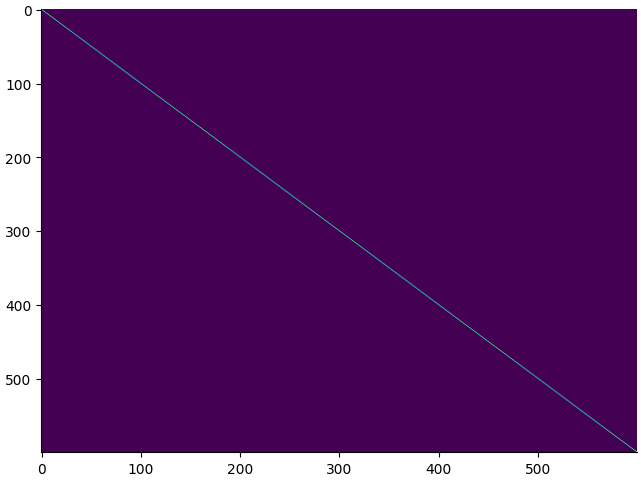

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) * 0 # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_, kernel_width+_)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [9]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [11]:
w0_mean_HVC2E, w0_std_HVC2E = 1/N_HVC, 1e-3
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_HVC2E = w0_mean_HVC2E
w_inh_E2E = w0_mean_E2E*cW_E2E
tauE, tauI, dt = 30, 10, 1

In [12]:
netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, phi, tauE, 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

Not a recurrent model and rI will not be calculated.


In [13]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-5e-2, 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsFF = _[2]
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-8e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsEI = _[2]
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-2e-1), 
                         tauW=1e5, J0_mean=J0_mean, asyn_E=10, rE_th=1)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsEIrec = _[2]

100%|███████████████████████████████████| 15499/15499 [00:14<00:00, 1055.18it/s]


Text(0, 0.5, 'Exc. index')

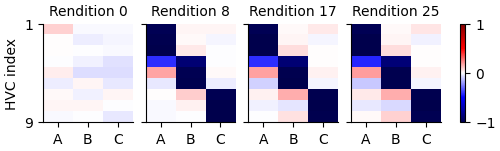

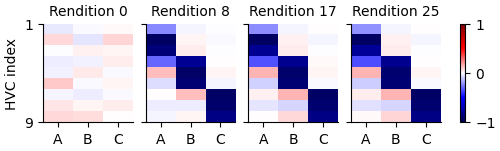

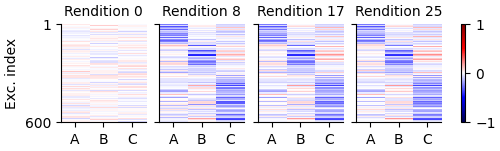

In [14]:
fig, ax = plot_wcol_corr(WsFF, syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEI['HVC'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEIrec['JEE'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('Exc. index')

## Test Model with Different Scenarios

In [15]:
T_test = T_burn + T_rend
i_pert = 1
res = dict(FF=[], EI=[], EIrec=[])
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert = rng.multivariate_normal(np.zeros(NE), pert_cov)

trial_params = ((1,0), (0,0.5), (0,1))
N_trials = len(trial_params)
for i, j in trial_params:
    bos = syl.copy()
    bos[i_pert] = syl[i_pert] * i + pert * j
    aud_test = generate_discrete_aud(T_test, NE, tsyl_start[:,:1], tsyl_end[:,:1], bos)
    args = (rH[:T_test], aud_test, [], T_test, dt, 0)
    res['FF'].append(netFF.sim(hE0, *args, no_progress_bar=True)[0])
    res['EI'].append(np.hstack(netEI.sim(hE0, hI0, *args, no_progress_bar=True)[:2]))
    res['EIrec'].append(np.hstack(netEIrec.sim(hE0, hI0, *args, no_progress_bar=True)[:2]))
for k, v in res.items():
    res[k] = np.stack(v, axis=0)

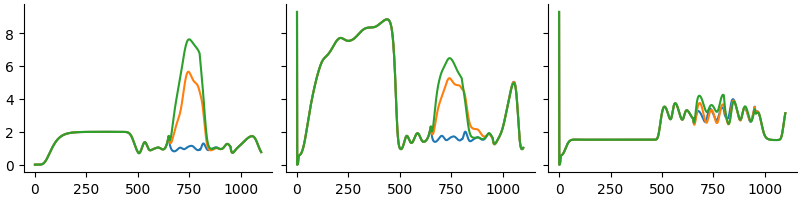

In [16]:
fig, ax = plt.subplots(1, 3, sharey='all', figsize=(8,2))
for i, (k, v) in enumerate(res.items()):
    for j, _ in enumerate(trial_params):
        ax[i].plot(v[j].mean(axis=-1));

Text(0.5, 1.0, 'EI network\n(E$\\to$E)')

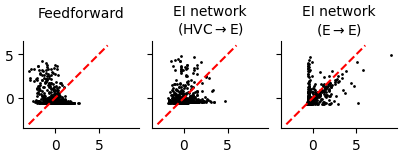

In [17]:
ti, tj = int(tsyl_start[i_pert,0])-100, int(tsyl_end[i_pert,0])+100
fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(4, 3))
for i, k in enumerate(res.keys()):
    z_ctrl = normalize(res[k][0:1,ti:tj,:NE].mean(axis=(0,1)), axis=0)
    z_pert = normalize(res[k][2:3,ti:tj,:NE].mean(axis=(0,1)), axis=0)
    # z_ctrl = res[k][0:1,ti:tj,:NE].mean(axis=(0,1))
    # z_pert = res[k][-3:,ti:tj,:NE].mean(axis=(0,1))
    ax[i].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
    ax[i].plot([-3,6], [-3,6], c='r', ls='--')
    # ax[i].set(aspect=1, xlim=[-3,6], ylim=[-3,6])
    ax[i].set(aspect=1)
ax[0].set_title('Feedforward\n', fontsize=10)
ax[1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[2].set_title('EI network\n(E$\\to$E)', fontsize=10)

Text(0.5, 1.0, 'EI network\n(E$\\to$E)')

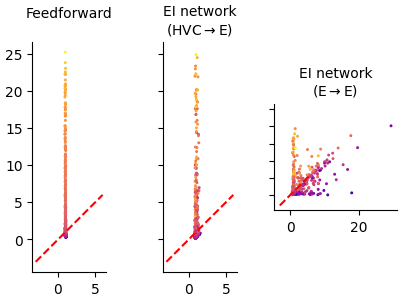

In [18]:
ti, tj = int(tsyl_start[i_pert,0])-100, int(tsyl_end[i_pert,0])+100
err = bos[i_pert] - syl[i_pert]
fig, ax = plt.subplots(1, 3, sharex=None, sharey='all', figsize=(4, 3))
for i, k in enumerate(res.keys()):
    # z_ctrl = normalize(res[k][0:1,ti:tj,:NE].mean(axis=(0,1)), axis=0)
    # z_pert = normalize(res[k][2:3,ti:tj,:NE].mean(axis=(0,1)), axis=0)
    z_ctrl = res[k][0:1,ti:tj,:NE].mean(axis=(0,1))
    z_pert = res[k][2:3,ti:tj,:NE].mean(axis=(0,1))
    ax[i].scatter(z_ctrl, z_pert, c=err, s=5, cmap='plasma')
    ax[i].plot([-3,6], [-3,6], c='r', ls='--')
    # ax[i].set(aspect=1, xlim=[-3,6], ylim=[-3,6])
    ax[i].set(aspect=1)
ax[0].set_title('Feedforward\n', fontsize=10)
ax[1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[2].set_title('EI network\n(E$\\to$E)', fontsize=10)

In [19]:
from sklearn.decomposition import PCA
def PCA_proj(data, n_components=3):
    pca = PCA(n_components=n_components).fit(normalize(data, axis=0))
    return pca, data @ pca.components_[:n_components].T
t_pca_start, t_pca_end = 500, int(tsyl_end[-1,0])#+50
pcaFF = PCA_proj(np.vstack(res['FF'][:,t_pca_start:t_pca_end,:NE]))
pcaEI = PCA_proj(np.vstack(res['EI'][:,t_pca_start:t_pca_end,:NE]))
pcaEIrec = PCA_proj(np.vstack(res['EIrec'][:,t_pca_start:t_pca_end,:NE]))

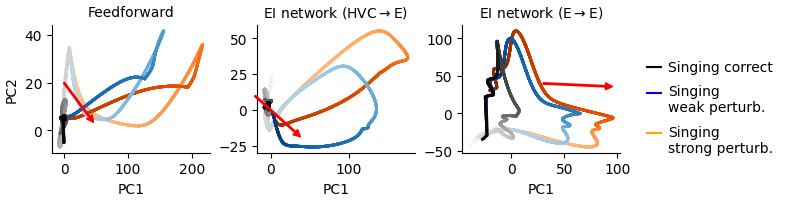

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharey='col')
arrow_origin = ((0, 20), (-20, 10), (30, 40))
    
for k, pca in enumerate((pcaFF, pcaEI, pcaEIrec)):
    for i, cmap in zip((2, 1, 0), ('Oranges', 'Blues', 'Greys')):
        c = plt.get_cmap(cmap)
        ti, tj = i*(pca[1].shape[0]//N_trials)+50, (i+1)*(pca[1].shape[0]//N_trials)-50
        t = np.arange(ti, tj, step=5)
        for j in range(len(t)-1):
            ax[k].plot(*pca[1][t[j]:t[j]+len(t)+1,[0,1]].T, color=c(j/len(t)), lw=2)

    # draw error direction
    u = pca[0].components_[[0,1]] @ (pert[i_pert] - syl[i_pert])
    u = 0.8 * u + arrow_origin[k]
    ax[k].annotate('', xy=u, xytext=arrow_origin[k], annotation_clip=False,
                     arrowprops=dict(color='r', width=1, headlength=5, 
                                     headwidth=5, shrink=0))
    # u = pca[0].components_[[0,1]] @ syl[i_pert]
    # u = 0.8 * u + arrow_origin[k]
    # ax[k].annotate('', xy=u, xytext=arrow_origin[k], annotation_clip=False,
    #                  arrowprops=dict(color='g', width=1, headlength=5, 
    #                                  headwidth=5, shrink=0))
    # u = pca[0].components_[[0,1]] @ pert[i_pert]
    # u = 0.8 * u + arrow_origin[k]
    # ax[k].annotate('', xy=u, xytext=arrow_origin[k], annotation_clip=False,
    #                  arrowprops=dict(color='b', width=1, headlength=5, 
    #                                  headwidth=5, shrink=0))

for i, l in enumerate(('Feedforward', 'EI network (HVC$\\to$E)', 'EI network (E$\\to$E)')):
    ax[i].set(title=l)
    ax[i].set(xlabel='PC1')
ax[0].set(ylabel='PC2')

# dummy
ax[-1].set_axis_off()
l1, = ax[-1].plot(0, 0, c='k', label='Singing correct')
l2, = ax[-1].plot(0, 0, c='b', label='\nSinging\nweak perturb.')
l3, = ax[-1].plot(0, 0, c='orange', label='\nSinging\nstrong perturb.')
fig.legend(handles=[l1], loc=(0.8, 0.6))
fig.legend(handles=[l2], loc=(0.8, 0.4))
fig.legend(handles=[l3], loc=(0.8, 0.2))

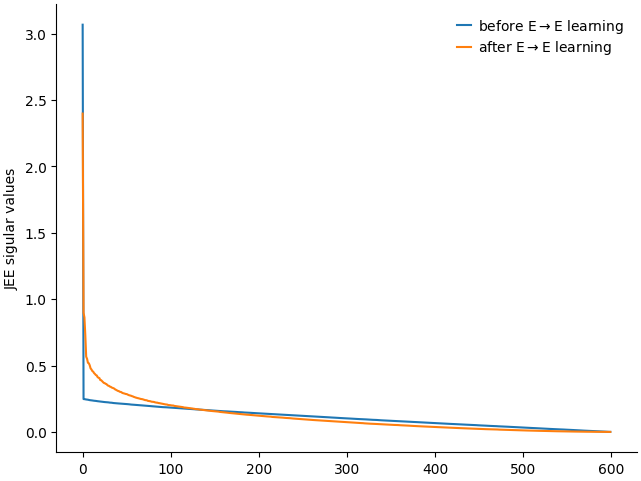

In [21]:
from scipy.linalg import svd
svd_EI = svd(netEI.JEE.toarray())
plt.plot(svd_EI[1], label='before E$\\to$E learning')

svd_EIrec = svd(netEIrec.JEE.toarray())
plt.plot(svd_EIrec[1], label='after E$\\to$E learning')
# plt.xlim([-1, 50])
plt.ylabel('JEE sigular values')
plt.legend()